In [ ]:
import csv
import pandas as pd

# Open the CSV file in read mode
with open('/content/data.csv', mode='r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)

    # Iterate through the rows in the CSV file
    for row in csv_reader:
        # Each row is a list of values, where each value corresponds to a column in the CSV
        # You can access specific columns by their index in the row list
        print(row)


['index', 'title', 'description', 'figure', 'references', 'definition', 'keywords', 'prediction', 'object']
['11.', 'project risk managment', 'project risk management includes the processes of conducting risk management planning, identification, analysis,  response planning, response implementation, and monitoring risk on a project. the objectives of project risk management  are to increase the probability and/or impact of positive risks and to decrease the probability and/or impact of negative  risks, in order to optimize the chances of project success. the project risk management processes are: 11.1 plan risk managementthe process of defining how to conduct risk management activities for a project. 11.2 identify risksthe process of identifying individual project risks as well as sources of overall project risk,  and documenting their characteristics. 11.3 perform qualitative risk analysisthe process of prioritizing individual project risks for further analysis  or action by assessing

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import networkx as nx

# Load your DataFrame
df = pd.read_csv('/content/data.csv')

# Prepare data for Word2Vec
# Combine titles and objects, and handle missing values
nodes = pd.concat([df['title'], df['object']]).dropna().unique()
edges = df['prediction'].dropna().unique()

# Tokenize for Word2Vec training
all_words = [word for text in nodes.tolist() + edges.tolist() for word in str(text).split()]

# Train Word2Vec model
model = Word2Vec([all_words], vector_size=100, window=5, min_count=1, workers=4)

# Generate embeddings for nodes and edges
node_embeddings = {node: np.mean([model.wv[word] for word in str(node).split() if word in model.wv] or [np.zeros(100)], axis=0) for node in nodes}
edge_embeddings = {edge: np.mean([model.wv[word] for word in str(edge).split() if word in model.wv] or [np.zeros(100)], axis=0) for edge in edges}


In [ ]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with embeddings to the graph
for node, emb in node_embeddings.items():
    G.add_node(node, embedding=emb)

# Add edges with embeddings to the graph
for _, row in df.iterrows():
    if pd.notna(row['title']) and pd.notna(row['object']) and pd.notna(row['prediction']):
        G.add_edge(row['title'], row['object'], embedding=edge_embeddings[row['prediction']])


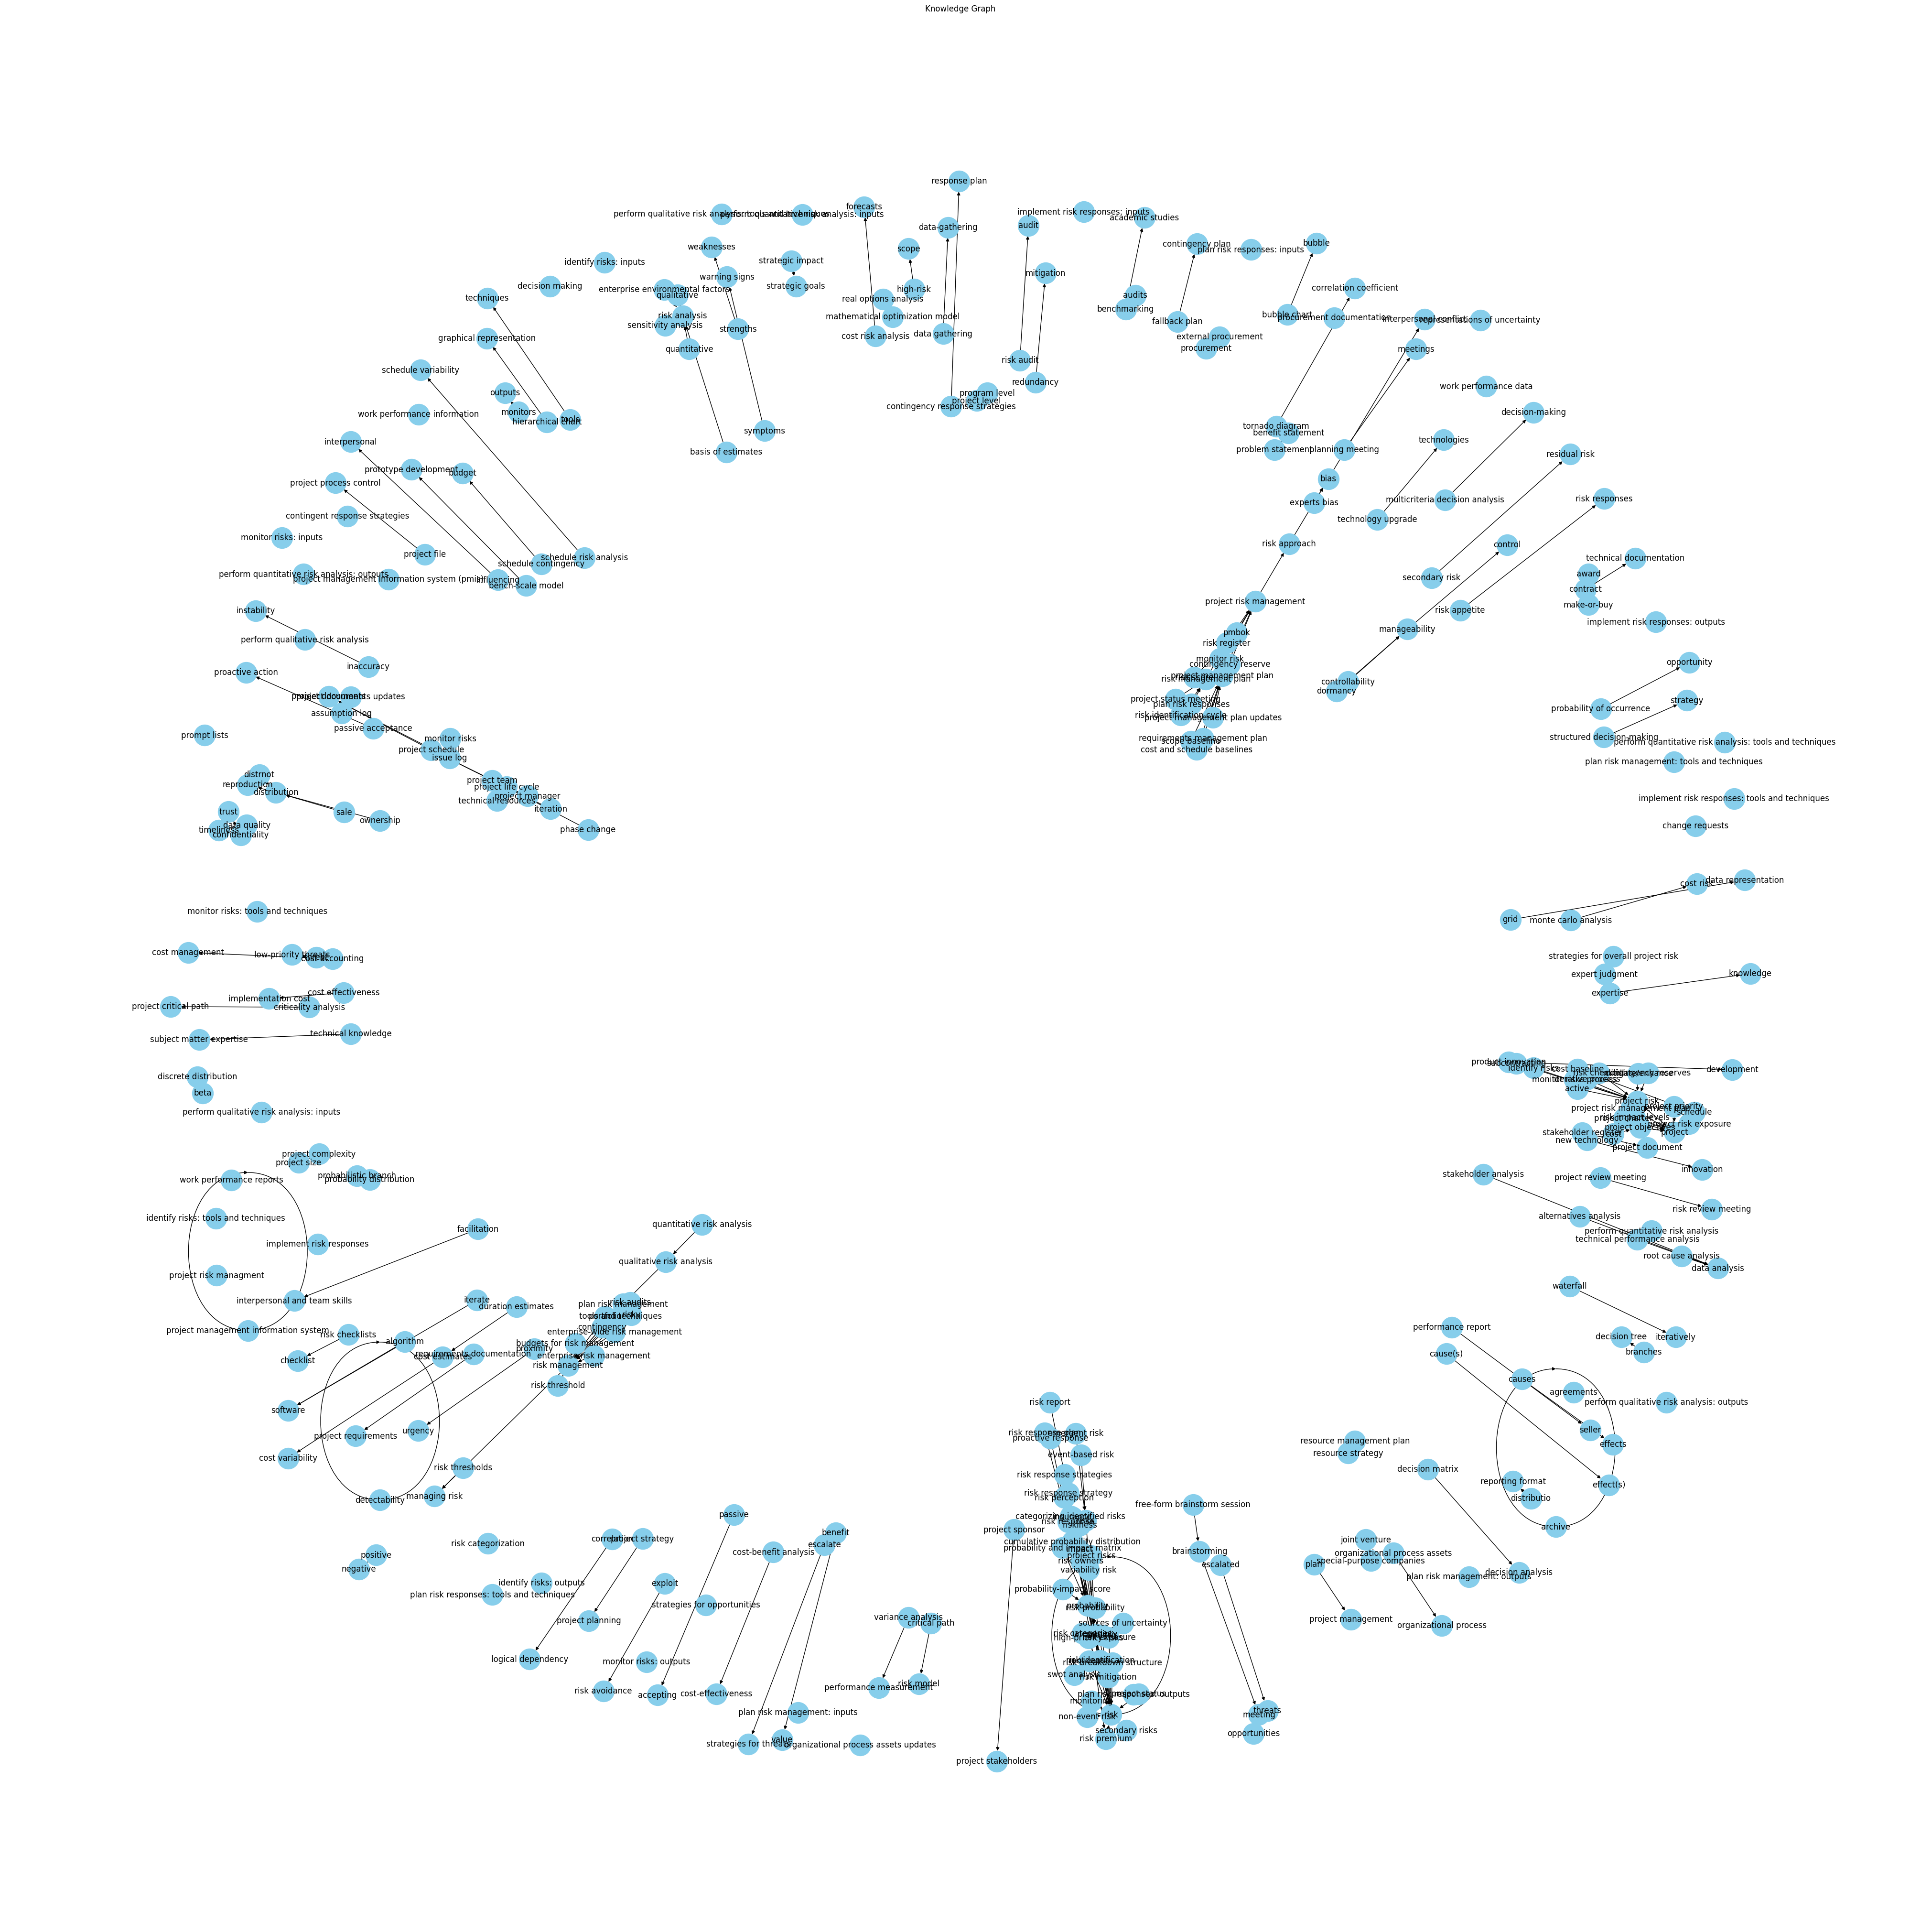

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your graph
pos = nx.spring_layout(G)  # Choose the layout algorithm

# Node labels - using node names as labels
labels = {node: node for node in G.nodes()}

# Edge labels - assuming predictions as labels
edge_labels = {(u, v): G[u][v]['embedding'] for u, v in G.edges()}

# Visualization
plt.figure(figsize=(40, 40))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=1000, node_color='skyblue', font_size=12)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Knowledge Graph")
plt.axis('off')
plt.show()


In [ ]:
!pip install dgl torch


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import networkx as nx

In [ ]:
num_nodes = len(set(df['title'].dropna().unique()).union(set(df['object'].dropna().unique())))

g = dgl.DGLGraph()
g.add_nodes(num_nodes)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
df.fillna({'keywords': '', 'description': '', 'definition': ''}, inplace=True)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=50)
combined_text = df['definition'] + " " + df['description'] + " " + df['keywords']
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)
tfidf_features = tfidf_matrix.toarray()

# Create a NetworkX graph
G = nx.Graph()
for _, row in df.iterrows():
    title = str(row['title'])
    obj = str(row['object'])
    G.add_node(title)
    G.add_node(obj)
    if pd.notna(row['prediction']):
        G.add_edge(title, obj, prediction=row['prediction'])

title_to_features = dict(zip(df['title'], tfidf_features))
for node in G.nodes():
    G.nodes[node]['features'] = title_to_features.get(node, np.zeros(tfidf_vectorizer.max_features))

# Convert to DGL graph
g_dgl = dgl.from_networkx(G, node_attrs=['features'])
g_dgl = dgl.add_self_loop(g_dgl)
features_tensor = torch.tensor(np.array([G.nodes[node]['features'] for node in G.nodes()]), dtype=torch.float32)

# GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl.nn.GraphConv(h_feats, in_feats)  # Output layer matches input feature size

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = self.conv2(g, h)  # Output is the reconstructed features
        return h

in_feats = features_tensor.shape[1]
h_feats = 64
model = GCN(in_feats, h_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function - Mean Squared Error for feature reconstruction
loss_function = nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    reconstructed_features = model(g_dgl, features_tensor)
    loss = loss_function(reconstructed_features, features_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch} | Loss: {loss.item()}')

# The model now has learned node representations

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return th.as_tensor(data, dtype=dtype)


Epoch 0 | Loss: 0.004411938134580851
Epoch 1 | Loss: 0.003442273708060384
Epoch 2 | Loss: 0.002997026778757572
Epoch 3 | Loss: 0.0027465149760246277
Epoch 4 | Loss: 0.0026041895616799593
Epoch 5 | Loss: 0.002501358976587653
Epoch 6 | Loss: 0.0024016464594751596
Epoch 7 | Loss: 0.0023087167646735907
Epoch 8 | Loss: 0.0022346656769514084
Epoch 9 | Loss: 0.0021828769240528345
Epoch 10 | Loss: 0.0021418274845927954
Epoch 11 | Loss: 0.0021012388169765472
Epoch 12 | Loss: 0.0020599907729774714
Epoch 13 | Loss: 0.0020188663620501757
Epoch 14 | Loss: 0.0019793447572737932
Epoch 15 | Loss: 0.001944611663930118
Epoch 16 | Loss: 0.001912317587994039
Epoch 17 | Loss: 0.0018799807876348495
Epoch 18 | Loss: 0.0018472429364919662
Epoch 19 | Loss: 0.0018170855473726988
Epoch 20 | Loss: 0.0017900491366162896
Epoch 21 | Loss: 0.001765341847203672
Epoch 22 | Loss: 0.0017431488959118724
Epoch 23 | Loss: 0.0017232164973393083
Epoch 24 | Loss: 0.0017044376581907272
Epoch 25 | Loss: 0.0016870844410732388
Epo

In [ ]:
import networkx as nx

# Assuming G is your graph
dgl.save_graphs("my_dgl_graph.bin", [g_dgl])


In [ ]:
# Assuming the model is already trained
model.eval()
with torch.no_grad():
    reconstructed_test_features = model(g_dgl, features_tensor)  # Replace features_tensor with test features if available
    test_loss = loss_function(reconstructed_test_features, features_tensor)  # Replace features_tensor with test features
    print(f"Reconstruction Loss on Test Set: {test_loss.item()}")
print(reconstructed_test_features.shape)


Reconstruction Loss on Test Set: 0.001293760142289102
torch.Size([340, 50])


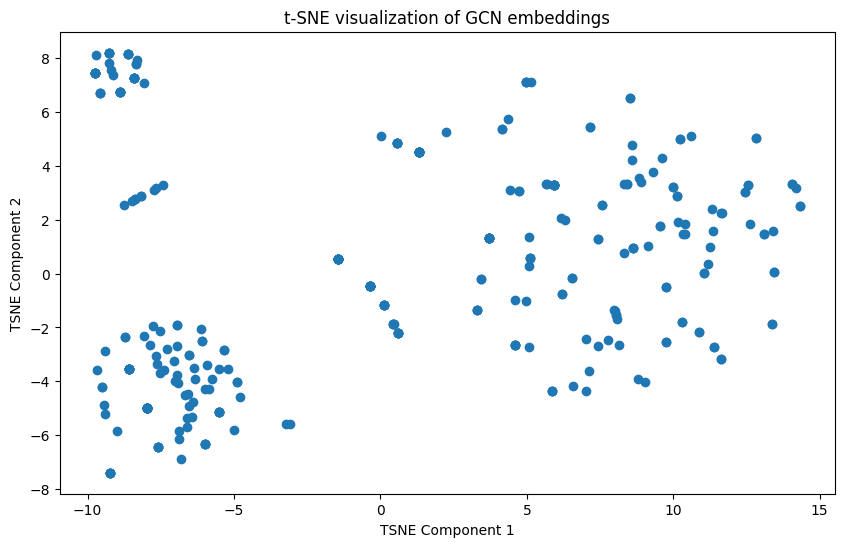

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

try:
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(reconstructed_test_features)
except Exception as e:
    print("An error occurred during t-SNE transformation:", e)


# Ensure embeddings are 2D (num_nodes, num_features)


if 'tsne_results' in locals():
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('t-SNE visualization of GCN embeddings')
    plt.show()
else:
    print("t-SNE results are not available.")


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Generate embeddings for all nodes
model.eval()
with torch.no_grad():
    all_embeddings = model(g_dgl, features_tensor).numpy()

# Function to recommend items based on cosine similarity
def recommend_items(user_node, all_embeddings, top_k=5):
    user_embedding = all_embeddings[user_node]
    similarities = cosine_similarity([user_embedding], all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return top_indices  # Indices of top-k recommended nodes

# Example: Recommend items for a specific user
user_node = 2 # Index of the user node in the graph
recommended_nodes = recommend_items(user_node, all_embeddings, top_k=5)
print(f"Top recommended nodes for user {user_node}: {recommended_nodes}")


Top recommended nodes for user 2: [  2 215 311 257  98]


In [ ]:
# Split the graph into training and pseudo-test sets (for demonstration purposes)
# In a real scenario, you should have a separate test set
num_nodes = g_dgl.number_of_nodes()
test_size = int(num_nodes * 0.2)
train_size = num_nodes - test_size

train_mask = torch.zeros(num_nodes, dtype=torch.bool).bernoulli(0.8)
test_mask = ~train_mask

# Evaluate the model on the pseudo-test set
model.eval()
with torch.no_grad():
    all_embeddings = model(g_dgl, features_tensor)
    test_embeddings = all_embeddings[test_mask]
    test_features = features_tensor[test_mask]
    test_loss = loss_function(test_embeddings, test_features)
    print(f"Test Reconstruction Loss: {test_loss.item()}")


Test Reconstruction Loss: 0.0017979331314563751


In [ ]:
# Hyperparameter tuning: trying different numbers of hidden features
hidden_features_options = [32, 64, 128]
for h_feats in hidden_features_options:
    model = GCN(in_feats, h_feats)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(50):  # Reduced number of epochs for quicker experimentation
        model.train()
        train_embeddings = model(g_dgl, features_tensor)
        train_loss = loss_function(train_embeddings[train_mask], features_tensor[train_mask])

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_embeddings = model(g_dgl, features_tensor)
        test_loss = loss_function(test_embeddings[test_mask], features_tensor[test_mask])
        print(f"Hidden Features: {h_feats}, Test Loss: {test_loss.item()}")


Hidden Features: 32, Test Loss: 0.004666868597269058
Hidden Features: 64, Test Loss: 0.005233687814325094
Hidden Features: 128, Test Loss: 0.005217988975346088


In [ ]:
# Generate embeddings for all nodes
model.eval()
with torch.no_grad():
    all_embeddings = model(g_dgl, features_tensor).numpy()

def refined_recommendations(user_node, all_embeddings, item_indices, top_k=5):
    user_embedding = all_embeddings[user_node]
    item_embeddings = all_embeddings[item_indices]
    similarities = cosine_similarity([user_embedding], item_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return [item_indices[i] for i in top_indices]

# Example: Making refined recommendations for a user
user_node = [2]  # Example user node index; now as a list
item_indices = [i for i in range(num_nodes) if i not in user_node]  # Assuming item nodes are separate from user nodes

# Call the refined_recommendations function
refined_recommendations_results = refined_recommendations(user_node[0], all_embeddings, item_indices, top_k=5)
print(f"Refined recommendations for user {user_node[0]}: {refined_recommendations_results}")


Refined recommendations for user 2: [215, 69, 17, 10, 7]


In [ ]:
# Saving the model
torch.save(model.state_dict(), 'gcn_model.pth')

# Loading the model
model = GCN(in_feats, h_feats)
model.load_state_dict(torch.load('gcn_model.pth'))
model.eval()

GCN(
  (conv1): GraphConv(in=50, out=128, normalization=both, activation=None)
  (conv2): GraphConv(in=128, out=50, normalization=both, activation=None)
)

In [ ]:
import random

# Assuming a certain number of nodes are users and the rest are items
num_users = 330 # Example number
num_items = num_nodes - num_users
pseudo_ground_truth = {user: random.sample(range(num_users, num_nodes), 10) for user in range(num_users)}
top_k = 5
recommendations = {user: recommend_items(user, all_embeddings, top_k) for user in range(num_users)}
def simple_accuracy(recommendations, ground_truth):
    correct = 0
    total = 0
    for user in recommendations:
        correct += len(set(recommendations[user]) & set(ground_truth[user]))
        total += len(recommendations[user])
    return correct / total if total > 0 else 0

accuracy = simple_accuracy(recommendations, pseudo_ground_truth)
print(f"Accuracy: {accuracy}")


Accuracy: 0.06060606060606061


Embeddings shape before transformation: torch.Size([340, 50])


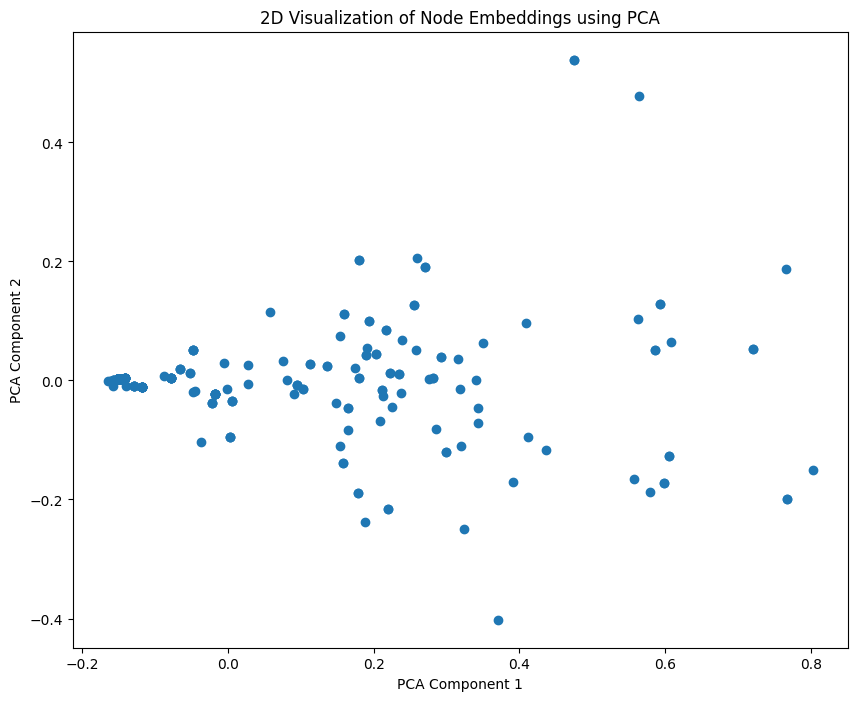

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Double-check the embeddings shape
print("Embeddings shape before transformation:", reconstructed_test_features.shape)

# Apply PCA for visualization as an alternative to t-SNE
pca = PCA(n_components=2)
try:
    embeddings_2d = pca.fit_transform(reconstructed_test_features)
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('2D Visualization of Node Embeddings using PCA')
    plt.show()
except Exception as e:
    print("Error during PCA transformation:", e)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def enhanced_recommend(user_node, all_embeddings, top_k=5):
    # Fetch the user's embedding
    user_embedding = all_embeddings[user_node]

    # Calculate cosine similarity scores between the user and all items
    similarity_scores = cosine_similarity([user_embedding], all_embeddings)[0]

    # Sort the items based on similarity scores
    recommended_items_indices = np.argsort(similarity_scores)[-top_k:][::-1]

    return recommended_items_indices

# Test the enhanced recommendation function
user_node = 2  # Example user node index
refined_recommendations = enhanced_recommend(user_node, all_embeddings, top_k=5)
print(f"Refined recommendations for user {user_node}: {refined_recommendations}")


Refined recommendations for user 2: [  2 215  17  69  10]


In [ ]:
user_sample = np.random.choice(range(num_nodes), size=10, replace=False)  # Select 10 random users for evaluation

for user_node in user_sample:
    recommended_nodes = enhanced_recommend(user_node, all_embeddings, top_k=5)
    print(f"User {user_node} recommendations: {recommended_nodes}")

User 241 recommendations: [339 156 186 185 182]
User 107 recommendations: [ 46 107 327  41  43]
User 119 recommendations: [ 34 311  98 257 119]
User 262 recommendations: [194 262 218 216 211]
User 202 recommendations: [202 228 323  85 283]
User 263 recommendations: [263 280 284 252 178]
User 298 recommendations: [298   4 117  92 129]
User 42 recommendations: [ 42 209 197 193  45]
User 225 recommendations: [268  96 270 146 285]
User 110 recommendations: [339 156 186 185 182]


In [ ]:
def get_user_input():
    try:
        user_id = int(input("Enter user ID for recommendations (0 to exit): "))
        if user_id == 0:
            return None
        elif user_id not in range(num_nodes):
            print("Invalid user ID. Please try again.")
            return get_user_input()
        return user_id
    except ValueError:
        print("Please enter a valid integer.")
        return get_user_input()

while True:
    user_id = get_user_input()
    if user_id is None:
        break

    recommended_nodes = enhanced_recommend(user_id, all_embeddings, top_k=5)
    print(f"Recommendations for User {user_id}: {recommended_nodes}")
    # Optionally, you can print more details about each recommendation if you have that data available.


Enter user ID for recommendations (0 to exit): 1
Recommendations for User 1: [339 156 186 185 182]
Enter user ID for recommendations (0 to exit): exit
Please enter a valid integer.
Enter user ID for recommendations (0 to exit): exit
Please enter a valid integer.
Enter user ID for recommendations (0 to exit): 0


In [ ]:
# Assuming 'title' and 'object' are the columns representing the nodes in your graph
all_nodes = pd.concat([df['title'], df['object']]).unique()

# Create a mapping for all unique nodes
item_titles = {index: node for index, node in enumerate(all_nodes)}


# Now you can use this mapping to interpret the recommendations
for user_id in range(1, 10):  # Example user IDs
    recommended_nodes = enhanced_recommend(user_id, all_embeddings, top_k=5)
    recommended_items = [item_titles.get(node, f"Unknown item ({node})") for node in recommended_nodes]
    print(f"Recommendations for User {user_id}: {recommended_items}")


Recommendations for User 1: ['technologies', 'problem statement', 'program level', 'iterative process', 'scope baseline']
Recommendations for User 2: ['plan risk management: inputs', 'planning meeting', 'procurement documentation', 'monitors', 'data analysis']
Recommendations for User 3: ['contingency', 'qualitative risk analysis', 'contingency reserves', 'hierarchical chart', 'proactive response']
Recommendations for User 4: ['project management plan', 'iteratively', 'multicriteria decision analysis', 'threats', 'categorizing identified risks']
Recommendations for User 5: ['project documents', 'monitor risks: tools and techniques', 'strategy', 'correlation coefficient', 'decision-making']
Recommendations for User 6: ['risk responses', 'outputs', 'value', 'high-priority risks', 'residual risk']
Recommendations for User 7: ['organizational process assets', 'plan risk management: inputs', 'planning meeting', 'data gathering', 'categorizing identified risks']
Recommendations for User 8: [

In [ ]:
# Pseudocode for assessing relevance - manually review the recommendations
for user_id in range(1, 10):
    recommended_items = enhanced_recommend(user_id, all_embeddings, top_k=5)
    print(f"User {user_id} recommendations: {recommended_items}")
    # Review each recommendation for its relevance to the user
    # This can involve checking if the items align with user preferences or needs


User 1 recommendations: [339 156 186 185 182]
User 2 recommendations: [  2 215  17  69  10]
User 3 recommendations: [212 152 150 149 148]
User 4 recommendations: [  4 298 117  92 129]
User 5 recommendations: [  5  57 317 301 286]
User 6 recommendations: [268  96 270 146 285]
User 7 recommendations: [  7   2 215  19 129]
User 8 recommendations: [226 261 172 199   8]
User 9 recommendations: [251   9  22  21 246]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def enhanced_recommend(user_node, all_embeddings, top_k=5):
    # Get the embedding for the user
    user_embedding = all_embeddings[user_node]

    # Calculate cosine similarities between user and all other nodes
    similarities = cosine_similarity([user_embedding], all_embeddings)[0]

    # Rank the nodes based on similarity scores
    ranked_nodes = np.argsort(similarities)[::-1]

    # Exclude the user node and get top-k items
    top_k_items = [node for node in ranked_nodes if node != user_node][:top_k]
    return top_k_items

# Assuming 'all_embeddings' is a NumPy array of node embeddings from your GNN model
for user_id in range(num_users):  # num_users is the total number of users
    recommended_nodes = enhanced_recommend(user_id, all_embeddings, top_k=5)
    print(f"Top recommended items for User {user_id}: {recommended_nodes}")


Top recommended items for User 0: [14, 74, 47, 39, 51]
Top recommended items for User 1: [339, 156, 186, 185, 182]
Top recommended items for User 2: [215, 17, 69, 10, 7]
Top recommended items for User 3: [212, 152, 150, 149, 148]
Top recommended items for User 4: [298, 117, 92, 129, 19]
Top recommended items for User 5: [57, 317, 301, 286, 63]
Top recommended items for User 6: [268, 96, 270, 146, 285]
Top recommended items for User 7: [2, 215, 19, 129, 92]
Top recommended items for User 8: [226, 261, 172, 199, 208]
Top recommended items for User 9: [251, 22, 21, 246, 35]
Top recommended items for User 10: [12, 248, 2, 72, 17]
Top recommended items for User 11: [315, 125, 37, 250, 177]
Top recommended items for User 12: [248, 10, 297, 234, 232]
Top recommended items for User 13: [339, 156, 186, 185, 182]
Top recommended items for User 14: [0, 74, 47, 39, 51]
Top recommended items for User 15: [331, 324, 59, 12, 248]
Top recommended items for User 16: [339, 156, 186, 185, 182]
Top recomm

In [ ]:
# Function to generate recommendations
def enhanced_recommend(user_node, all_embeddings, top_k=5):
    user_embedding = all_embeddings[user_node]
    similarities = cosine_similarity([user_embedding], all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    return top_indices  # Indices of top-k recommended nodes

# Assuming model is your trained GNN model and features_tensor contains node features
model.eval()
with torch.no_grad():
    all_embeddings = model(g_dgl, features_tensor).numpy()

# Generate and print recommendations for each user
for user_id in range(1, 10):  # Assuming you have 10 users for demonstration
    recommended_nodes = enhanced_recommend(user_id, all_embeddings, top_k=5)
    recommended_items = [item_titles.get(node, f"Item {node}") for node in recommended_nodes]
    print(f"Recommendations for User {user_id}: {recommended_items}")


Recommendations for User 1: ['technologies', 'problem statement', 'program level', 'iterative process', 'scope baseline']
Recommendations for User 2: ['plan risk management: inputs', 'planning meeting', 'procurement documentation', 'monitors', 'data analysis']
Recommendations for User 3: ['contingency', 'qualitative risk analysis', 'contingency reserves', 'hierarchical chart', 'proactive response']
Recommendations for User 4: ['project management plan', 'iteratively', 'multicriteria decision analysis', 'threats', 'categorizing identified risks']
Recommendations for User 5: ['project documents', 'monitor risks: tools and techniques', 'strategy', 'correlation coefficient', 'decision-making']
Recommendations for User 6: ['risk responses', 'outputs', 'value', 'high-priority risks', 'residual risk']
Recommendations for User 7: ['organizational process assets', 'plan risk management: inputs', 'planning meeting', 'data gathering', 'categorizing identified risks']
Recommendations for User 8: [

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming you have a pandas DataFrame 'df' with 'title' and 'object' columns
all_unique_titles = pd.concat([df['title'], df['object']]).unique()

# Initialize and fit the encoder
encoder = LabelEncoder()
encoder.fit(all_unique_titles)



def interactive_recommendation(model, user_input):
    user_node = encoder.transform([user_input])[0]  # Transform user input
    with torch.no_grad():
        all_embeddings = model(g, features_tensor).numpy()
    recommended_nodes, scores = recommend_items(user_node, all_embeddings, top_k=5)
    recommended_titles = encoder.inverse_transform(recommended_nodes)  # Inverse transform the recommendations
    return list(zip(recommended_titles, scores))

# Interactive loop
while True:
    user_input = input("Enter a title or object for recommendations (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break

    try:
        recommendations = interactive_recommendation(model, user_input)
        for title, score in recommendations:
            print(f"Recommended: {title} (Score: {score:.4f})")
    except Exception as e:
        print("An error occurred:", e)

Enter a title or object for recommendations (type 'exit' to quit): exit


In [ ]:
torch.save(model.state_dict(), 'gcn_model.pth')

# Function to make recommendations
def recommend_items(query_node, all_embeddings, encoder, top_k=5):
    query_index = encoder.transform([query_node])[0]
    query_embedding = all_embeddings[query_index]
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    top_nodes = encoder.inverse_transform(top_indices)
    return list(zip(top_nodes, similarities[top_indices]))

# Load the trained model for making recommendations
model = GCN(in_feats, h_feats)
model.load_state_dict(torch.load('gcn_model.pth'))
model.eval()

# Create label encoder
encoder = LabelEncoder()
encoder.fit(np.array(list(G.nodes())))

# Interactive recommendation
while True:
    query_node = input("Enter a title or object for recommendations (type 'exit' to quit): ")
    if query_node.lower() == 'exit':
        break

    if query_node not in encoder.classes_:
        print("Node not found in graph.")
        continue

    with torch.no_grad():
        all_embeddings = model(g_dgl, features_tensor).numpy()

    recommendations = recommend_items(query_node, all_embeddings, encoder)
    for title, score in recommendations:
        print(f"Recommended: {title} (Score: {score:.4f})")

Enter a title or object for recommendations (type 'exit' to quit): risk
Recommended: risk (Score: 1.0000)
Recommended: categorizing identified risks (Score: 0.8689)
Recommended: product innovation (Score: 0.4548)
Recommended: development (Score: 0.4548)
Recommended: multicriteria decision analysis (Score: 0.4275)
Enter a title or object for recommendations (type 'exit' to quit): exit


In [ ]:
!pip install python-Levenshtein

In [ ]:
import torch
import Levenshtein
from sklearn.preprocessing import LabelEncoder

# Load the trained model
model = GCN(in_feats, h_feats)
model.load_state_dict(torch.load('gcn_model.pth'))
model.eval()

# Create label encoder
encoder = LabelEncoder()
all_nodes = np.array(list(G.nodes()))
encoder.fit(all_nodes)

# Precompute embeddings
with torch.no_grad():
    precomputed_embeddings = model(g_dgl, features_tensor).numpy()

def find_closest_match(query, all_nodes):
    similarities = [Levenshtein.ratio(query, node) for node in all_nodes]
    closest_match = all_nodes[np.argmax(similarities)]
    return closest_match

def recommend_items(query_node, all_embeddings, encoder, top_k=5):
    query_index = encoder.transform([query_node])[0]
    query_embedding = all_embeddings[query_index]
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    top_nodes = encoder.inverse_transform(top_indices)
    return list(zip(top_nodes, similarities[top_indices]))

# Interactive recommendation loop
while True:
    query_node = input("Enter a title or object for recommendations (type 'exit' to quit): ")
    if query_node.lower() == 'exit':
        break

    if query_node not in encoder.classes_:
        closest_match = find_closest_match(query_node, all_nodes)
        user_confirmation = input(f"Node not found in graph. Did you mean: {closest_match}? (yes/no): ")
        if user_confirmation.lower() != 'yes':
            continue
        query_node = closest_match

    with torch.no_grad():
        all_embeddings = model(g_dgl, features_tensor).numpy()

    recommendations = recommend_items(query_node, precomputed_embeddings, encoder)
    for title, score in recommendations:
        print(f"Recommended: {title} (Score: {score:.4f})")

Enter a title or object for recommendations (type 'exit' to quit): risk mang
Node not found in graph. Did you mean: risk management? (yes/no):  yes
Enter a title or object for recommendations (type 'exit' to quit): risk mang
Node not found in graph. Did you mean: risk management? (yes/no): yes
Recommended: risk management (Score: 1.0000)
Recommended: risk threshold (Score: 0.9896)
Recommended: risky (Score: 0.9896)
Recommended: risk audits (Score: 0.9896)
Recommended: portfolio (Score: 0.9896)
Enter a title or object for recommendations (type 'exit' to quit): exit


In [ ]:
# Define your test scenarios
test_scenarios = [
    "project risk management",
    "financial risk assessment",
    "cybersecurity threat",
    "market volatility",
    "compliance regulation risks",
    # Add more scenarios as needed
]

# Update the graph with descriptions
for _, row in df.iterrows():
    title = row['title']
    description = row['description']
    if title in G:
        G.nodes[title]['description'] = description

# Recommendation function (assuming it's already defined and working correctly)

# Function to test a single scenario
def test_scenario(scenario, model, embeddings, encoder, g, top_k=5):
    print(f"Testing scenario: '{scenario}'")
    recommendations = recommend_items(scenario, embeddings, encoder, g, top_k)
    for title, score, description in recommendations:
        print(f"Recommended: {title} (Score: {score:.4f}) - Description: {description}")
    print("\n")

# Perform tests
for scenario in test_scenarios:
    test_scenario(scenario, model, precomputed_embeddings, encoder, G, top_k=5)

Testing scenario: 'project risk management'
Recommended: project risk management (Score: 1.0000) - Description: 
Recommended: contingency reserve (Score: 0.8182) - Description: 
Recommended: project objectives (Score: 0.8055) - Description: 
Recommended: cost (Score: 0.8049) - Description: 
Recommended: project (Score: 0.7933) - Description: No description available


Testing scenario: 'financial risk assessment'
Node not found.


Testing scenario: 'cybersecurity threat'
Node not found.


Testing scenario: 'market volatility'
Node not found.


Testing scenario: 'compliance regulation risks'
Node not found.




In [ ]:

!pip install pyngrok


In [ ]:
!pip install -q streamlit

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import torch
import dgl
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import networkx as nx

# Load your DataFrame
df = pd.read_csv('/content/data.csv')

# Prepare data for Word2Vec
# Combine titles and objects, and handle missing values
nodes = pd.concat([df['title'], df['object']]).dropna().unique()
edges = df['prediction'].dropna().unique()

# Tokenize for Word2Vec training
all_words = [word for text in nodes.tolist() + edges.tolist() for word in str(text).split()]

# Train Word2Vec model
model = Word2Vec([all_words], vector_size=100, window=5, min_count=1, workers=4)

# Generate embeddings for nodes and edges
node_embeddings = {node: np.mean([model.wv[word] for word in str(node).split() if word in model.wv] or [np.zeros(100)], axis=0) for node in nodes}
edge_embeddings = {edge: np.mean([model.wv[word] for word in str(edge).split() if word in model.wv] or [np.zeros(100)], axis=0) for edge in edges}
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import networkx as nx
num_nodes = len(set(df['title'].dropna().unique()).union(set(df['object'].dropna().unique())))

g = dgl.DGLGraph()
g.add_nodes(num_nodes)
df.fillna({'keywords': '', 'description': '', 'definition': ''}, inplace=True)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=50)
combined_text = df['definition'] + " " + df['description'] + " " + df['keywords']
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)
tfidf_features = tfidf_matrix.toarray()

# Create a NetworkX graph
G = nx.Graph()
for _, row in df.iterrows():
    title = str(row['title'])
    obj = str(row['object'])
    G.add_node(title)
    G.add_node(obj)
    if pd.notna(row['prediction']):
        G.add_edge(title, obj, prediction=row['prediction'])

title_to_features = dict(zip(df['title'], tfidf_features))
for node in G.nodes():
    G.nodes[node]['features'] = title_to_features.get(node, np.zeros(tfidf_vectorizer.max_features))

# Convert to DGL graph
g_dgl = dgl.from_networkx(G, node_attrs=['features'])
g_dgl = dgl.add_self_loop(g_dgl)
features_tensor = torch.tensor(np.array([G.nodes[node]['features'] for node in G.nodes()]), dtype=torch.float32)

# GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl.nn.GraphConv(h_feats, in_feats)  # Output layer matches input feature size

    def forward(self, g, in_feat):
        h = F.relu(self.conv1(g, in_feat))
        h = self.conv2(g, h)  # Output is the reconstructed features
        return h

in_feats = features_tensor.shape[1]
h_feats = 64
model = GCN(in_feats, h_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function - Mean Squared Error for feature reconstruction
loss_function = nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    reconstructed_features = model(g_dgl, features_tensor)
    loss = loss_function(reconstructed_features, features_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch} | Loss: {loss.item()}')

import torch
import Levenshtein
from sklearn.preprocessing import LabelEncoder

# Create label encoder
encoder = LabelEncoder()
all_nodes = np.array(list(G.nodes()))
encoder.fit(all_nodes)

# Precompute embeddings
with torch.no_grad():
    precomputed_embeddings = model(g_dgl, features_tensor).numpy()

def find_closest_match(query, all_nodes):
    similarities = [Levenshtein.ratio(query, node) for node in all_nodes]
    closest_match = all_nodes[np.argmax(similarities)]
    return closest_match

def recommend_items(query_node, all_embeddings, encoder, g, top_k=5):
    if query_node not in encoder.classes_:
        print("Node not found.")
        return []
    query_index = encoder.transform([query_node])[0]
    query_embedding = all_embeddings[query_index]
    similarities = cosine_similarity([query_embedding], all_embeddings)[0]
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    top_nodes = encoder.inverse_transform(top_indices)

    recommendations = []
    for node, score in zip(top_nodes, similarities[top_indices]):
        node_description = g.nodes[node].get('description', 'No description available')
        recommendations.append((node, score, node_description))

    return recommendations

# Streamlit UI for recommendations
st.title("Graph-Based Recommendation System")
user_input = st.text_input("Enter a title or object for recommendations", "")

if user_input:
    if user_input.lower() == 'exit':
        st.write("Exiting...")
    else:
        recommendations = recommend_items(user_input, precomputed_embeddings, encoder, G, top_k=5)
        if recommendations:
            for title, score, description in recommendations:
                st.subheader(f"Recommended: {title} (Score: {score:.4f})")
                st.text("Description: " + description)
        else:
            st.write("No recommendations found.")

Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.946s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.227.39.53
npx: installed 22 in 4.492s
your url is: https://major-falcons-stop.loca.lt
